In [22]:
import time
import astroquery.heasarc
from astropy.coordinates import SkyCoord
import astropy.units as u

from astroquery.jplhorizons import Horizons
import numpy as np
import pandas as pd

from collections import defaultdict

from astropy.time import Time

import getpass
import oda_api.token

import logging

from oda_api.api import DispatcherAPI

from oda_api.plot_tools import OdaImage

import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.patches import Circle

We want to find the ScWs that contain Jupiter (within 8 degrees) for given dates. To do this we look at Jupiter's position on the sky each month and search correspondingly for ScWs. If none, move on to next month. 

In [23]:
epochs = {'start':'2003-01-01', 'stop':'2004-01-01', 'step':'30d'}

jupiter = Horizons(id='599', location='@0',epochs=epochs) 
eph = jupiter.ephemerides()
#print(eph)

df = eph.to_pandas()
df['datetime_str'] = pd.to_datetime(df['datetime_str'])
monthly_means = df.groupby(df['datetime_str'].dt.strftime('%Y-%m'))[['RA', 'DEC']].mean()
for month, row in monthly_means.iterrows():
    print(f"Month: {month}, Mean RA: {row['RA']:.2f} deg, Mean DEC: {row['DEC']:.2f} deg")

ra_values = eph['RA']  # in degrees
dec_values = eph['DEC']  # in degrees
# print(eph[['datetime_str', 'RA', 'DEC']])

# let's calculate the mean change in Jupiter's position in the sky per day
coords = SkyCoord(ra=np.array(ra_values) * u.deg, dec=np.array(dec_values) * u.deg, frame='icrs')
angular_separations = coords[:-1].separation(coords[1:])
mean_change = np.mean(angular_separations) # .to(u.arcmin)
# print(f"Mean change in Jupiter's position per week: {mean_change:.3f}")


Month: 2003-01, Mean RA: 134.35 deg, Mean DEC: 17.92 deg
Month: 2003-03, Mean RA: 137.97 deg, Mean DEC: 16.97 deg
Month: 2003-04, Mean RA: 140.34 deg, Mean DEC: 16.29 deg
Month: 2003-05, Mean RA: 143.86 deg, Mean DEC: 15.24 deg
Month: 2003-06, Mean RA: 147.33 deg, Mean DEC: 14.14 deg
Month: 2003-07, Mean RA: 149.61 deg, Mean DEC: 13.38 deg
Month: 2003-08, Mean RA: 151.87 deg, Mean DEC: 12.60 deg
Month: 2003-09, Mean RA: 154.11 deg, Mean DEC: 11.81 deg
Month: 2003-10, Mean RA: 156.33 deg, Mean DEC: 11.00 deg
Month: 2003-11, Mean RA: 158.54 deg, Mean DEC: 10.18 deg
Month: 2003-12, Mean RA: 160.72 deg, Mean DEC: 9.34 deg


In [ ]:
# ScWs from 2003, with Jupiter in FOV (within 8 degree search radius)
ScWs2003 = ["008200180010.001", "008200190010.001", "008200190010.001"]

Before moving on to using this query for our ODA, we need to input our token (use local file so don't need to input it every time). Need to update it regularly however.

In [3]:
# token = ''
# token = getpass.getpass('Insert the token')
token = oda_api.token.discover_token() # get token stored locally

We also add logging to help visualize the process.

In [4]:
logging.getLogger().setLevel(logging.INFO) # WARNING, INFO or DEBUG
logging.getLogger('oda_api').addHandler(logging.StreamHandler())

Now let us look at an example.

In [5]:
disp = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock")

par_dict = {
"E1_keV": "15",
"E2_keV": "30",
"T_format": "isot",
"detection_threshold": "5",
"instrument": "isgri",
"osa_version": "OSA10.2",
"product": "isgri_image",
"product_type": "Real",
"scw_list": ["027300510010.001"],
'token': token
}
# "integral_data_rights": "all-private" had to be removed as didn't have the rights

data_collection = disp.get_product(**par_dict)
data_collection.show()
data_collection.mosaic_image_0_mosaic.show()

print(data_collection.mosaic_image_0_mosaic.show_meta())


found token in TokenLocation.FILE_CUR_DIR your token payload: {
    "email": "hucklethums@icloud.com",
    "exp": 1741779981,
    "name": "interstellxr",
    "roles": "authenticated user, public-pool-hpc",
    "sub": "hucklethums@icloud.com"
}
token expires in 335.2 h
discovered token in environment
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
- waiting for remote response (since 2025-02-26 13:33:46), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: HKSUUIGHKW3SZTRO job: e3931b9ed64f9ea6

... query status prepared => done
... assigned job id: e3931b9ed64f9ea6
query COMPLETED SUCCESSFULLY (state done)
query complete: terminating


ID=0 prod_name=mosaic_image_0_mosaic  meta_data: {'product': 'mosaic', 'instrument': 'isgri', 'src_name': '', 'query_parameters': None}

ID=1 prod_name=dispatcher_catalog_1  meta_data: 

------------------------------
name: mosaic_image
meta_data dict_keys(['product', 'instrument', 'src_name', 'query_parameters'])
number of data units 6
------------------------------
data uniti 0 ,name: PRIMARY
data uniti 1 ,name: GROUPING
data uniti 2 ,name: ISGR-MOSA-IMA
data uniti 3 ,name: ISGR-MOSA-IMA
data uniti 4 ,name: ISGR-MOSA-IMA
data uniti 5 ,name: ISGR-MOSA-IMA
------------------------------
product : mosaic
instrument : isgri
src_name : 
query_parameters : None
------------------------------
None


Finally, let us image our results and save the image to a fits file.

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 53378.351875 from DATE-OBS.
Set MJD-END to 53378.376331 from DATE-END'. [astropy.wcs.wcs]
/home/hthums/micromamba/envs/jupiter_xray/lib/python3.9/site-packages/oda_api/plot_tools.py:101: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


'./027300510010.001mosaic.fits'

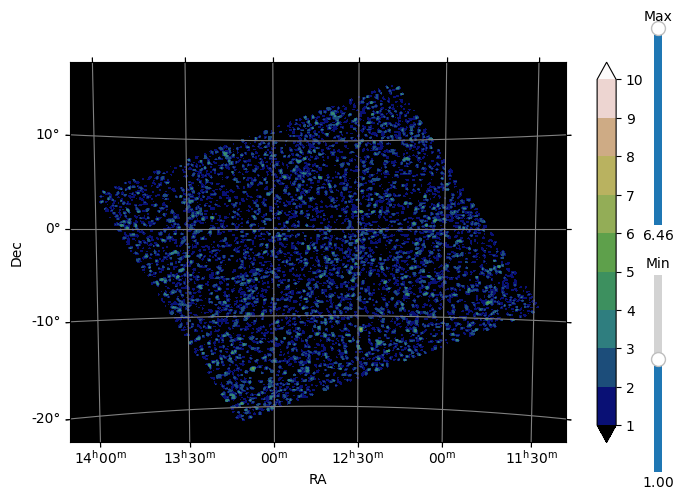

In [6]:
im=OdaImage(data_collection)
_ = im.show()
im.write_fits('027300510010.001')

Let us find Jupiter's position for the duration of the ScW.

In [7]:
epochs = {'start':"2005-01-08T08:26:42.6", 'stop':"2005-01-08T09:01:55.6", 'step':'10m'}
jupiter = Horizons(id='599', location='@0',epochs=epochs)
eph = jupiter.ephemerides()
ra_values = eph['RA']  
dec_values = eph['DEC']  
print(eph[['datetime_str', 'RA', 'DEC']])

      datetime_str           RA      DEC   
          ---               deg      deg   
------------------------ --------- --------
2005-Jan-08 08:26:42.600 187.36929 -1.76614
2005-Jan-08 08:36:42.600 187.36977 -1.76634
2005-Jan-08 08:46:42.600 187.37025 -1.76655
2005-Jan-08 08:56:42.600 187.37073 -1.76676


We can plot the image with a marker on Jupiter's expected position. We choose a marker size to represent Jupiter's main oval (30 * size of Jupiter).

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 53378.351875 from DATE-OBS.
Set MJD-END to 53378.376331 from DATE-END'. [astropy.wcs.wcs]
/tmp/ipykernel_12629/830575022.py:18: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(image_data), cmap='plasma', origin='lower')
/tmp/ipykernel_12629/830575022.py:18: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(image_data), cmap='plasma', origin='lower')
/tmp/ipykernel_12629/830575022.py:23: RuntimeWarning: cdelt will be ignored since cd is present
  pixel_scale = np.abs(wcs.wcs.cdelt[0])*3600.0  # pixel size in arcseconds


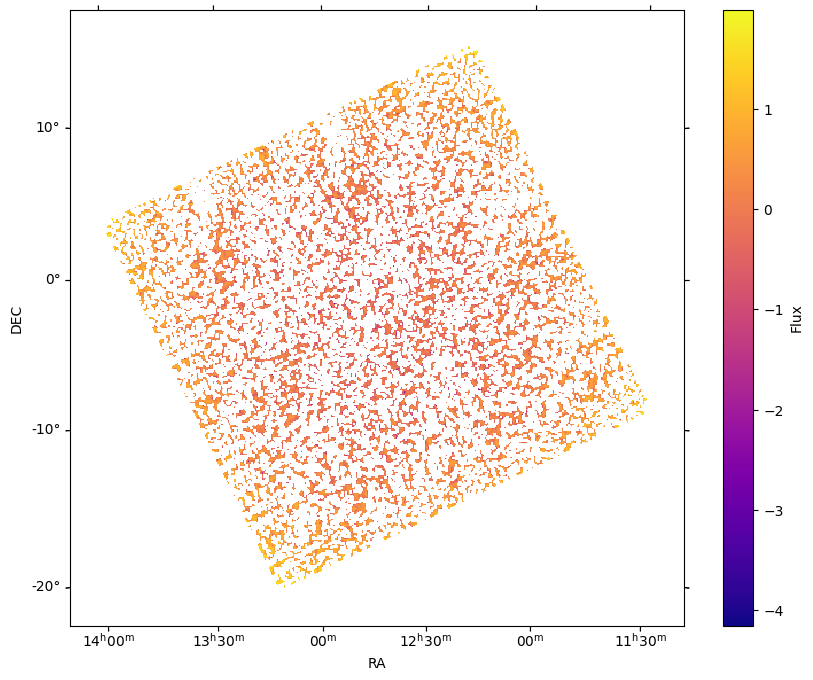

In [27]:
from astropy.wcs import WCS
from matplotlib.patches import Circle

fits_file = "027300510010.001mosaic.fits"

# Jupiter
ra_deg = ra_values[0]
dec_deg = dec_values[0]

with fits.open(fits_file) as hdul:
    image_data = hdul[2].data 
    wcs = WCS(hdul[2].header)  

x, y = wcs.all_world2pix(ra_deg, dec_deg, 1)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=wcs)
im = ax.imshow(np.log10(image_data), cmap='plasma', origin='lower')

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

pixel_scale = np.abs(wcs.wcs.cdelt[0])*3600.0  # pixel size in arcseconds
circle_radius_pixels = 30 * 50 / pixel_scale / 2  # radius in pixels

circle = Circle((x, y), circle_radius_pixels, edgecolor='black', facecolor='black', lw=2)
ax.add_patch(circle)

plt.colorbar(im, label="Flux")
plt.show()
